In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score

In [26]:
CATEGORY_MAPPING = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [27]:
def load_and_preprocess_data():
    dataset_name = "fancyzhx/ag_news"
    dataset = load_dataset(dataset_name)
    
    train_df = dataset["train"].to_pandas()
    test_df = dataset["test"].to_pandas()
    
    train_df['Category'] = train_df['label'].map(CATEGORY_MAPPING)
    test_df['Category'] = test_df['label'].map(CATEGORY_MAPPING)
    
    return train_df, test_df

In [28]:
def build_pipeline(best_alpha=0.1):
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000)),
        ("clf", MultinomialNB(alpha=best_alpha))
    ])
    return pipeline

In [29]:
def tune_hyperparameters(X_train, y_train):
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000)),
        ("clf", MultinomialNB())
    ])

    param_grid = {'clf__alpha': [0.01, 0.1, 0.5, 1, 5, 10]}  
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_alpha = grid_search.best_params_['clf__alpha']
    print(f"Best Alpha: {best_alpha}")
    return best_alpha

In [30]:
def train_naive_bayes(X_train, y_train):
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10]}
    grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_alpha = grid_search.best_params_['alpha']
    print(f"Best Alpha: {best_alpha}")  
    
    model = MultinomialNB(alpha=best_alpha)
    model.fit(X_train, y_train)
    return model

In [31]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()

Best Alpha: 0.01
=== Test Set Performance ===
Accuracy: 0.8523684210526316
Classification Report:
               precision    recall  f1-score   support

    Business       0.82      0.80      0.81      1900
    Sci/Tech       0.82      0.81      0.81      1900
      Sports       0.90      0.94      0.92      1900
       World       0.86      0.87      0.87      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

=== Cross-Validation on Training Set ===
CV Accuracy Scores: [0.85433333 0.85333333 0.86066667 0.85775    0.85658333]
Mean CV Accuracy: 0.8565 ± 0.0026


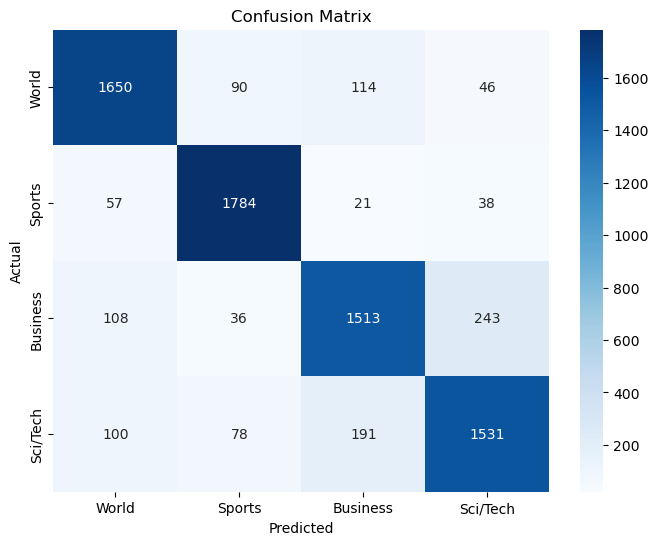

=== Usage Example ===
Text: Wall Street sees renewed optimism in tech stocks
Predicted Label: Business

Text: Soccer World Cup final brings excitement worldwide
Predicted Label: Sports



In [32]:
train_df, test_df = load_and_preprocess_data()
X_train = train_df['text']
y_train = train_df['Category']
X_test = test_df['text']
y_test = test_df['Category']

# Tune hyperparameters
best_alpha = tune_hyperparameters(X_train, y_train)

# Train final pipeline with best alpha
pipeline = build_pipeline(best_alpha)
pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = pipeline.predict(X_test)
print("=== Test Set Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Cross-validation on the training set
print("=== Cross-Validation on Training Set ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Performance Analysis: Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=list(CATEGORY_MAPPING.values()))

# Usage Example: Predict new samples
new_samples = [
    "Wall Street sees renewed optimism in tech stocks",
    "Soccer World Cup final brings excitement worldwide"
]
predictions = pipeline.predict(new_samples)
print("=== Usage Example ===")
for text, pred in zip(new_samples, predictions):
    print(f"Text: {text}\nPredicted Label: {pred}\n")